In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform, MaskedPiecewiseRationalQuadraticAutoregressiveTransform

from nflows.transforms.permutations import ReversePermutation

In [2]:
E0 = 500
R = 0.4

In [3]:
def target_p(x):

    mean = 0
    std = 1

    # Gaussian 
    p = 1/np.sqrt(2 * np.pi  * std**2) * np.exp(- (x - mean)**2 / 2 / std**2)
    return p



def Theta(x):
    return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))

def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def LO_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return -torch.nan_to_num((2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * torch.log(lambda_ ) / lambda_ * Theta(1 - lambda_) * Theta(lambda_))

def LL_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return torch.nan_to_num(LO_angularity(lambda_, beta) * torch.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)) * Theta(1 - lambda_) * Theta(lambda_))


In [4]:
# Loss function
def calc_dkl(logp, logq, train_from_samples):


    if train_from_samples:
        return -(logp - logq).sum(dim = 1).nanmean()# reverse KL, assuming samples from q
        
    else:
        return -(logp.exp()*(logq - logp)).sum(dim = 1).nanmean()# reverse KL, assuming samples from q

In [5]:
base_dist = StandardNormal(shape=[1])

num_layers = 4
num_hidden_features = 128 # relaed to network width
num_blocks = 10 # related to network depth
num_bins = 10 # essentially how many piecewise splines we want
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=1))
    transforms.append(MaskedAffineAutoregressiveTransform(features=1, hidden_features = 128))
    # transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(features = 1, 
    #                                   hidden_features = num_hidden_features, num_blocks = num_blocks, tail_bound = 5, 
    #                                               num_bins = num_bins, tails = "linear"))

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters(), lr = 0.001)


In [6]:
from tqdm import tqdm

num_epochs = 200
train_losses = []

batch_size = 512

train_from_samples = False


def correct_f(z):
    return z*np.sqrt(sigmasq) + mean

def correct_f_inv(x):
    return (x - mean)/np.sqrt(sigmasq)

def correct_dx_dz(z):
    return np.sqrt(sigmasq)

def correct_dz_dx(x):
    return 1/np.sqrt(sigmasq)


t = tqdm(range(num_epochs))
for i in t:
    
    optimizer.zero_grad()
    
    if train_from_samples:
        
        # SAMPLE FROM THE PRIOR z
        z_samples = flow._distribution.sample(batch_size) 
        
        # APPLY FLOW TO PRIOR
        logp_of_z = flow._distribution.log_prob(z_samples)
        x_samples, log_dx_dz = flow._transform(z_samples)
        logq = logp_of_z - log_dx_dz
        

    else:
        
        # PULL VALUES OF x
        # x_samples = torch.linspace(-10, 10, steps = batch_size).reshape(-1,1)

        # Random uniform noise
        x_samples = torch.rand(batch_size, 1)
    
        # APPLY INVERSE FLOW TO x
        z_samples, log_dz_dx = flow._transform.inverse(x_samples)
        log_p_of_z = flow._distribution.log_prob(z_samples) 


        # # x_samples = torch.normal(mean, np.sqrt(sigmasq), (batch_size, 1))
        # z_samples = correct_f_inv(x_samples)
        # log_dz_dx = np.log(correct_dz_dx(x_samples))
        # log_p_of_z = flow._distribution.log_prob(z_samples) 




        # test_z = torch.rand(1000, 1)*20 - 10
        # test_x_samples = correct_f(test_z)
        # plt.plot(test_z.detach().numpy(), test_x_samples.detach().numpy(), 'o')
        # plt.plot(test_z, test_z*np.sqrt(sigmasq) + mean, 'r')

        logq = log_p_of_z + log_dz_dx
        logq = torch.reshape(logq, (-1, 1)) # KEY FIX FOR TRAINING ISSUE



        
        
    logp = torch.log(LL_angularity(x_samples))
    loss = calc_dkl(logp, logq, train_from_samples)

    print()
    print(logp)
    print(logq)
    print(loss)


    # plt.plot(x_samples.detach().cpu().numpy(), logq.detach().cpu().numpy(), 'o', alpha = 0.5)
    # plt.plot(x_samples.detach().cpu().numpy(), logp.detach().cpu().numpy(), 'x', alpha = 0.5)
    # plt.xlim(-5, 5)

    
    loss.backward()
    optimizer.step()
        
    train_losses.append(loss.detach().cpu().numpy())
    t.set_description('loss %.2f' % train_losses[-1])

    

  0%|          | 0/200 [00:00<?, ?it/s]

loss 3.77:   0%|          | 1/200 [00:00<02:05,  1.59it/s]


tensor([[-1.9964e+00],
        [-7.7837e-01],
        [ 1.3762e+00],
        [-2.1864e+00],
        [ 1.3687e+00],
        [-5.0290e+00],
        [-1.2664e+00],
        [-1.2509e+00],
        [-1.8969e-01],
        [-2.1067e+00],
        [-4.7732e-01],
        [-6.4125e-01],
        [-3.1264e+00],
        [ 4.8794e-01],
        [-4.6076e+00],
        [-3.2494e+00],
        [-7.7414e-01],
        [-1.5470e+00],
        [-4.1415e+00],
        [ 1.3169e-01],
        [-1.4184e+00],
        [-3.7988e+00],
        [-1.2817e+00],
        [ 4.5728e-01],
        [ 8.9310e-01],
        [-1.6843e+00],
        [-2.5569e+00],
        [-2.0549e+00],
        [-1.2785e+00],
        [-1.3964e+00],
        [-3.1555e+00],
        [-2.5219e+00],
        [ 1.7506e-01],
        [-2.3571e+00],
        [-5.2564e-01],
        [ 1.0554e-01],
        [ 2.1552e-01],
        [ 1.3302e+00],
        [-2.9005e-01],
        [-2.8855e+00],
        [-4.7367e+00],
        [-2.1398e+00],
        [-1.6567e+00],
        [ 

loss 0.36:   1%|          | 2/200 [00:00<01:11,  2.76it/s]


tensor([[ -2.8748],
        [ -2.3418],
        [ -2.0557],
        [  0.2377],
        [ -6.1118],
        [ -0.7898],
        [ -0.1390],
        [ -1.0635],
        [ -2.3434],
        [ -1.7361],
        [ -1.2954],
        [ -1.4914],
        [ -1.8810],
        [ -3.1968],
        [ -0.3197],
        [ -3.1141],
        [ -1.3302],
        [ -0.9203],
        [ -4.4789],
        [ -1.4187],
        [  1.1597],
        [ -4.1664],
        [ -1.9196],
        [ -1.4577],
        [ -2.9814],
        [ -2.2135],
        [ -1.7294],
        [ -0.8997],
        [ -2.0023],
        [ -1.2109],
        [ -0.7700],
        [ -1.0684],
        [ -0.7355],
        [ -1.3389],
        [ -0.1862],
        [ -2.4409],
        [ -0.1814],
        [  0.9025],
        [ -1.8315],
        [ -3.7413],
        [ -1.6386],
        [ -3.4656],
        [ -1.8472],
        [ -3.1096],
        [ -4.2334],
        [ -0.9738],
        [ -2.9939],
        [  0.4945],
        [ -0.2291],
        [ -2.2450],

loss 1.30:   2%|▏         | 3/200 [00:01<01:02,  3.15it/s]

tensor([[-2.9604e+00],
        [-3.0344e-01],
        [-1.6408e+00],
        [ 1.5238e+00],
        [-2.4582e+00],
        [ 1.3733e-01],
        [-1.3827e+00],
        [ 1.5582e+00],
        [-7.0695e-01],
        [ 6.4448e-01],
        [-4.9680e+00],
        [-3.1183e+00],
        [-5.4529e+00],
        [-1.5087e+00],
        [-3.8458e+00],
        [ 1.6209e-01],
        [-2.3987e+00],
        [-2.9893e+00],
        [-1.6919e+00],
        [ 1.5454e+00],
        [-3.7082e+00],
        [-6.9068e-01],
        [ 6.4815e-01],
        [-4.5897e+00],
        [-4.2506e+00],
        [-2.0693e+00],
        [-4.1492e-01],
        [-6.7358e-03],
        [ 7.6655e-01],
        [ 4.3925e-01],
        [-1.7882e-01],
        [-1.7255e+00],
        [ 7.5215e-01],
        [-1.1890e+00],
        [-2.3259e+00],
        [-2.9075e+00],
        [ 7.6319e-01],
        [-3.4926e+00],
        [-3.5133e+00],
        [-3.1841e+00],
        [-1.9399e+00],
        [-6.6867e-01],
        [-3.5928e+00],
        [ 7

loss nan:   2%|▏         | 3/200 [00:01<01:02,  3.15it/s] 

tensor([[-5.5677e+00],
        [ 7.6384e-01],
        [-2.2436e+00],
        [-3.8089e+00],
        [-1.7721e+00],
        [-4.6172e-01],
        [ 1.3835e+00],
        [-1.5966e+00],
        [-1.8302e+00],
        [-2.3639e+00],
        [ 8.4714e-01],
        [-2.3315e+00],
        [-6.7245e-01],
        [ 1.3358e+00],
        [ 8.6184e-01],
        [-1.5976e+00],
        [-3.8128e-02],
        [-7.0074e+00],
        [-6.7040e-01],
        [-1.0138e+00],
        [-3.4879e+00],
        [ 1.1094e+00],
        [ 6.8649e-01],
        [ 5.4285e-01],
        [-2.8744e+00],
        [ 6.6106e-01],
        [ 1.2787e+00],
        [ 1.8919e-01],
        [-1.5834e+00],
        [-4.3275e+00],
        [-1.7404e+00],
        [ 1.3299e-01],
        [-1.2899e+00],
        [ 1.4376e+00],
        [-2.0075e-01],
        [-7.1301e+00],
        [-2.1396e-01],
        [ 6.2021e-01],
        [-2.2438e+00],
        [-2.1668e+00],
        [-2.0055e+00],
        [ 2.4881e-01],
        [-2.5883e+00],
        [-9

loss nan:   2%|▏         | 4/200 [00:01<01:03,  3.09it/s]


tensor([[ 2.9472e-01],
        [-5.6822e-01],
        [-5.7684e+00],
        [ 4.2480e-01],
        [-2.0093e+00],
        [ 7.8046e-01],
        [-1.2449e+00],
        [-2.2624e+00],
        [-4.6299e+00],
        [-3.1862e+00],
        [ 8.4617e-01],
        [ 4.4801e-01],
        [-1.2841e+00],
        [-3.2663e-01],
        [-4.2257e-01],
        [-1.5455e-01],
        [ 3.8350e-01],
        [-1.7594e+00],
        [-2.7474e+00],
        [-2.6128e-01],
        [-1.7176e+00],
        [-1.6798e+00],
        [ 1.3910e+00],
        [-5.2985e-01],
        [-3.3846e+00],
        [ 1.1811e+00],
        [-9.5777e-01],
        [-2.8267e+00],
        [-3.0974e+00],
        [-1.9700e+00],
        [-3.2705e+00],
        [-3.3626e+00],
        [-5.3448e-01],
        [-1.2661e+00],
        [-2.9150e+00],
        [-2.7322e+00],
        [ 9.1316e-01],
        [ 1.3305e-02],
        [ 8.7706e-01],
        [-1.7845e+00],
        [-2.3459e+00],
        [-1.1618e+00],
        [-7.2620e-01],
        [ 

loss nan:   3%|▎         | 6/200 [00:02<01:01,  3.16it/s]


tensor([[-1.2661e+00],
        [ 2.4046e-01],
        [-1.0973e+00],
        [-1.9728e+00],
        [-1.7849e+00],
        [-1.6645e+00],
        [-1.0607e-02],
        [ 5.4387e-01],
        [-4.5739e+00],
        [ 1.0084e+00],
        [-1.5348e+00],
        [ 1.5561e+00],
        [-3.1206e+00],
        [-3.5524e+00],
        [-1.3940e+00],
        [-2.5731e+00],
        [-3.5069e-01],
        [-1.0510e+00],
        [ 8.8921e-01],
        [-3.7652e+00],
        [-1.0461e+00],
        [ 1.3165e+00],
        [-3.6271e+00],
        [ 5.8129e-01],
        [ 2.8654e-01],
        [-4.4692e+00],
        [ 1.2757e+00],
        [ 1.5933e+00],
        [-1.4963e+00],
        [-3.1707e+00],
        [-2.6089e+00],
        [-6.5504e-01],
        [-2.7151e+00],
        [-3.0659e+00],
        [ 1.4184e+00],
        [ 7.1940e-01],
        [ 6.1589e-01],
        [-1.4041e+00],
        [ 2.8244e-03],
        [-2.2529e+00],
        [-7.4464e-01],
        [-2.9178e+00],
        [-2.6164e+00],
        [-

loss nan:   4%|▎         | 7/200 [00:02<01:29,  2.16it/s]


tensor([[-4.0066e+00],
        [-1.2222e+00],
        [-1.6413e+00],
        [-5.7473e-02],
        [-1.8407e+00],
        [ 1.2929e+00],
        [-7.0225e-01],
        [-2.0864e+00],
        [-7.5599e-02],
        [ 9.6324e-01],
        [-1.1735e+00],
        [-2.8060e-01],
        [-1.5663e-01],
        [ 1.1161e+00],
        [ 6.2070e-01],
        [-2.1269e+00],
        [ 1.0807e+00],
        [-2.9337e-02],
        [-2.4451e+00],
        [-2.1747e+00],
        [ 7.3894e-01],
        [-1.9433e+00],
        [-6.6865e+00],
        [-2.8640e+00],
        [-5.4482e+00],
        [-1.0297e+00],
        [-3.6148e+00],
        [ 1.5944e+00],
        [ 8.4606e-01],
        [-3.0546e-01],
        [-8.4447e-01],
        [-5.3724e+00],
        [ 6.2196e-01],
        [-8.4334e-01],
        [ 1.5477e+00],
        [-5.2166e+00],
        [-1.3309e+00],
        [-3.6977e+00],
        [-5.7756e+00],
        [-4.3498e-01],
        [-5.5482e+00],
        [ 1.1266e+00],
        [-9.8828e-02],
        [-

loss nan:   4%|▍         | 8/200 [00:03<01:32,  2.07it/s]


tensor([[ 1.5226e+00],
        [-6.3527e-01],
        [-7.1104e-01],
        [-3.5409e+00],
        [-2.1172e+00],
        [-3.9503e+00],
        [-5.4289e+00],
        [-2.9572e+00],
        [-1.6306e+00],
        [ 2.8773e-01],
        [-8.4086e-01],
        [ 2.7038e-01],
        [-5.8350e-01],
        [-2.7853e+00],
        [-1.6813e-01],
        [-1.0539e+00],
        [-2.0746e+00],
        [-1.2896e+00],
        [ 1.3539e+00],
        [-2.2653e+00],
        [ 1.4635e-01],
        [-2.8039e+00],
        [ 2.5715e-01],
        [-2.5207e+00],
        [ 4.4449e-01],
        [-7.2221e-01],
        [-1.0773e+00],
        [-3.2296e+00],
        [-2.1939e+00],
        [-3.0404e+00],
        [ 2.4076e-02],
        [-1.8454e+00],
        [-3.4837e+00],
        [-1.0738e+00],
        [-3.6747e+00],
        [-1.5481e+00],
        [-6.7499e+00],
        [-5.7216e-01],
        [-1.3175e+00],
        [-1.6572e+00],
        [-2.8514e+00],
        [-2.9654e+00],
        [-9.7487e-01],
        [-

loss nan:   4%|▍         | 9/200 [00:03<01:21,  2.35it/s]


tensor([[-3.5598e+00],
        [ 1.5583e+00],
        [-1.8780e+00],
        [-1.3236e+00],
        [-3.9124e+00],
        [-2.0297e+00],
        [ 3.2718e-02],
        [-1.2255e+00],
        [-2.8209e+00],
        [-2.5081e+00],
        [-3.0050e+00],
        [-4.1330e-01],
        [-1.3167e+00],
        [-1.6796e+00],
        [-6.4326e+00],
        [-7.1046e+00],
        [-9.5362e-02],
        [-3.2113e+00],
        [-1.6198e+00],
        [-1.1970e+00],
        [-4.1827e+00],
        [-4.4086e-02],
        [-1.4058e+00],
        [-1.8108e+00],
        [-1.6349e+00],
        [ 1.4673e+00],
        [ 1.4976e+00],
        [-4.4191e-01],
        [-4.0729e+00],
        [-2.3937e+00],
        [ 1.1200e-01],
        [ 1.2728e+00],
        [-5.4282e-01],
        [-3.4724e+00],
        [-3.0126e-01],
        [-9.6101e-01],
        [ 1.2236e-01],
        [ 3.0687e-01],
        [ 1.3966e+00],
        [-4.6921e-01],
        [ 1.1470e+00],
        [-7.1520e-01],
        [-1.5736e+00],
        [-

loss nan:   5%|▌         | 10/200 [00:03<01:13,  2.58it/s]


tensor([[-1.7931e+00],
        [ 3.2372e-01],
        [-2.5345e+00],
        [-1.1622e+00],
        [-1.7118e+00],
        [ 7.4434e-01],
        [-1.0929e-01],
        [-3.7375e+00],
        [-4.3837e+00],
        [ 6.4372e-01],
        [ 2.5429e-01],
        [ 5.7026e-01],
        [ 1.2182e+00],
        [-2.4062e-01],
        [-6.2145e-01],
        [-3.9404e+00],
        [-2.4122e+00],
        [-1.9875e+00],
        [-5.9242e-01],
        [-7.7507e-02],
        [-1.5763e+00],
        [-1.5047e+00],
        [-6.1263e-01],
        [-6.2629e-01],
        [ 3.4320e-01],
        [-2.1463e+00],
        [-1.3307e+00],
        [-1.7335e-01],
        [-1.6571e+00],
        [-1.5192e+00],
        [-8.2754e-01],
        [-3.4357e+00],
        [-2.8018e+00],
        [-9.3028e-01],
        [ 9.4195e-01],
        [-2.0988e+00],
        [-1.9134e+00],
        [-3.5121e+00],
        [-6.3670e-01],
        [-1.9818e+00],
        [-2.9876e-02],
        [ 5.0168e-01],
        [-3.2246e+00],
        [-

loss nan:   6%|▌         | 12/200 [00:04<00:59,  3.15it/s]


tensor([[-1.0943e+00],
        [-3.8274e+00],
        [ 2.4510e-01],
        [-2.4505e-01],
        [-4.5119e+00],
        [-4.4869e+00],
        [ 1.0100e+00],
        [-1.1426e+00],
        [-4.0303e+00],
        [ 8.2417e-01],
        [-2.8546e+00],
        [-4.2731e+00],
        [-1.5069e+00],
        [-3.8440e+00],
        [-7.8989e-01],
        [-8.7199e-01],
        [-2.0808e+00],
        [-2.8156e+00],
        [-7.2797e+00],
        [-2.5229e+00],
        [-3.5171e-01],
        [-8.1712e-01],
        [-2.9496e+00],
        [-1.7515e-01],
        [-1.6705e+00],
        [-5.9194e-01],
        [-1.8097e+00],
        [-5.7235e-01],
        [-1.2862e-01],
        [-1.8031e+00],
        [-1.5749e+00],
        [-6.7065e+00],
        [-7.6115e-01],
        [-3.2530e+00],
        [-1.7966e+00],
        [-2.2017e+00],
        [-1.7820e+00],
        [-6.1022e+00],
        [ 9.7200e-01],
        [-5.1924e+00],
        [-1.5340e+00],
        [-1.8490e-01],
        [-5.5923e-01],
        [ 

loss nan:   7%|▋         | 14/200 [00:05<01:22,  2.25it/s]


tensor([[-3.2778],
        [-0.1782],
        [-4.7023],
        [-2.1516],
        [-0.5093],
        [-4.0612],
        [-2.2285],
        [-3.5375],
        [-2.8706],
        [-3.0084],
        [-1.3969],
        [-0.5857],
        [-1.1665],
        [-2.2090],
        [ 1.1908],
        [ 0.9424],
        [ 0.2729],
        [-4.6468],
        [ 0.3376],
        [-1.4907],
        [-0.4716],
        [-2.4842],
        [-0.7225],
        [-0.7527],
        [-0.4943],
        [-2.0415],
        [-4.6917],
        [ 1.2022],
        [-4.3524],
        [ 0.8374],
        [-1.4377],
        [-1.7233],
        [ 0.6583],
        [-2.4085],
        [-1.8568],
        [-1.7457],
        [-4.0212],
        [-0.1626],
        [-2.7398],
        [-1.7316],
        [-1.6975],
        [-0.8786],
        [-0.6148],
        [-1.8599],
        [-1.3443],
        [-0.8597],
        [-1.2893],
        [ 1.0847],
        [-4.1464],
        [-0.6354],
        [-2.1995],
        [-1.2219],
        [-4

loss nan:   8%|▊         | 15/200 [00:05<01:06,  2.79it/s]


tensor([[-2.3954e+00],
        [ 3.8156e-01],
        [ 1.2407e+00],
        [ 1.4330e+00],
        [-2.2800e+00],
        [-2.3669e+00],
        [-3.1035e+00],
        [-3.7748e+00],
        [-4.1559e-01],
        [-2.7771e+00],
        [-5.9500e+00],
        [-8.6228e-01],
        [ 1.3164e+00],
        [-2.1005e+00],
        [-1.3450e+00],
        [ 1.5955e+00],
        [-1.9765e+00],
        [-2.8203e+00],
        [ 3.4663e-02],
        [ 1.5417e+00],
        [-1.3395e+00],
        [-6.5414e+00],
        [ 6.5628e-02],
        [-2.6742e+00],
        [-4.1568e-01],
        [-3.5160e+00],
        [-2.0488e+00],
        [-4.9612e-01],
        [-3.1902e+00],
        [-7.0044e-01],
        [-2.5828e+00],
        [-3.3478e+00],
        [ 6.0375e-01],
        [-1.3565e+00],
        [-1.9711e-01],
        [-2.3012e+00],
        [-5.0685e-01],
        [ 3.9975e-01],
        [-3.1632e+00],
        [ 1.1789e+00],
        [-1.4973e+00],
        [ 1.5310e+00],
        [ 2.7010e-01],
        [-

loss nan:   8%|▊         | 17/200 [00:06<01:10,  2.58it/s]


tensor([[-6.3731e+00],
        [-1.1637e+00],
        [-2.0695e+00],
        [-2.8735e+00],
        [ 4.1799e-01],
        [-4.4336e-01],
        [-6.3859e+00],
        [-1.6769e+00],
        [-1.2059e+00],
        [-2.2739e+00],
        [ 1.1509e+00],
        [-5.1219e+00],
        [-4.0590e+00],
        [-2.0946e+00],
        [-2.0776e+00],
        [-3.0929e+00],
        [-1.1962e+00],
        [ 1.5550e+00],
        [-4.4619e-01],
        [-8.9820e-01],
        [-2.6536e-01],
        [-9.7155e-01],
        [-3.8334e+00],
        [-2.8945e+00],
        [-5.1328e-01],
        [ 4.8329e-01],
        [ 6.2741e-01],
        [ 1.6187e-01],
        [ 6.4974e-01],
        [-1.3221e+00],
        [-3.9037e+00],
        [-1.8873e+00],
        [ 8.3332e-01],
        [-1.7621e+00],
        [-2.2290e+00],
        [-1.1362e+00],
        [ 2.1974e-01],
        [-3.0343e-01],
        [-9.3094e-01],
        [-7.2719e-02],
        [-1.2262e+00],
        [-3.0911e+00],
        [ 3.2079e-01],
        [-

loss nan:   9%|▉         | 18/200 [00:06<01:00,  3.02it/s]

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

loss nan:  10%|▉         | 19/200 [00:07<00:54,  3.29it/s]


tensor([[-1.0637e+00],
        [-3.8214e-01],
        [-2.0853e+00],
        [-7.4425e-01],
        [-3.2291e+00],
        [-1.3150e+00],
        [-2.1227e-01],
        [-7.6112e-01],
        [-1.4090e+00],
        [-1.6786e+00],
        [-3.4326e+00],
        [ 1.1281e+00],
        [-1.7315e+00],
        [ 5.9282e-01],
        [ 1.4223e+00],
        [-2.5440e-01],
        [-1.0693e+00],
        [-4.7564e+00],
        [-1.5503e+00],
        [-1.9949e+00],
        [-3.5318e+00],
        [-3.8387e+00],
        [ 9.0188e-01],
        [ 1.5949e+00],
        [-2.7449e+00],
        [ 8.2728e-01],
        [-3.3706e+00],
        [-6.6262e-01],
        [ 1.4555e+00],
        [-3.7759e+00],
        [ 6.7421e-01],
        [-2.4813e+00],
        [ 4.4312e-01],
        [-3.0907e+00],
        [ 5.7657e-01],
        [ 5.6122e-01],
        [-1.2696e+00],
        [-1.1262e+00],
        [-6.9593e-01],
        [ 1.5310e+00],
        [-1.7602e+00],
        [-2.2516e+00],
        [-3.5454e-01],
        [-

loss nan:  10%|█         | 20/200 [00:07<01:04,  2.80it/s]


tensor([[  0.0368],
        [  0.4583],
        [ -4.4529],
        [ -0.3120],
        [ -2.0744],
        [ -2.3142],
        [  1.4681],
        [  0.1792],
        [ -3.9670],
        [ -4.6950],
        [ -0.8416],
        [  0.2187],
        [  0.7708],
        [ -6.7036],
        [ -0.1281],
        [  0.4569],
        [ -2.0036],
        [ -2.9093],
        [ -2.4487],
        [  1.4683],
        [ -1.5123],
        [ -1.2302],
        [ -1.8980],
        [ -0.9009],
        [ -1.2241],
        [ -1.7959],
        [ -2.9026],
        [  0.1574],
        [ -0.2452],
        [ -3.9838],
        [ -2.9935],
        [ -1.4247],
        [ -0.5492],
        [ -1.6538],
        [ -1.9173],
        [ -0.6809],
        [ -3.0791],
        [ -1.2899],
        [ -1.3506],
        [  0.3374],
        [ -0.3118],
        [  0.6385],
        [ -1.5593],
        [ -0.8488],
        [ -1.6546],
        [ -0.0698],
        [ -4.8167],
        [ -0.7344],
        [ -3.8676],
        [ -0.7204],

loss nan:  11%|█         | 22/200 [00:08<01:06,  2.69it/s]


tensor([[-4.1380e-02],
        [-1.2358e+00],
        [-2.4457e+00],
        [-1.7359e+00],
        [-3.6113e+00],
        [ 6.1881e-01],
        [-2.1014e+00],
        [-2.1577e+00],
        [-4.8170e-01],
        [-5.9599e+00],
        [-1.8867e+00],
        [-3.0442e+00],
        [-5.0899e+00],
        [-2.5074e+00],
        [-1.7177e+00],
        [-1.4815e+00],
        [-6.8847e-01],
        [-3.4710e+00],
        [-1.6736e+00],
        [ 9.4610e-01],
        [-2.0284e+00],
        [-2.5283e+00],
        [-1.5786e-02],
        [-4.7009e-01],
        [-2.9801e+00],
        [-1.5812e+00],
        [-9.1562e-02],
        [ 2.0228e-01],
        [-5.6770e+00],
        [-1.8799e-01],
        [ 5.6502e-01],
        [-2.5256e+00],
        [ 1.5751e+00],
        [-1.5371e+00],
        [-2.2892e+00],
        [-8.1064e-01],
        [-2.9104e+00],
        [-7.3448e-01],
        [-2.7168e+00],
        [-1.1266e+00],
        [-3.5376e+00],
        [-9.3586e-01],
        [-3.4308e+00],
        [-

loss nan:  12%|█▏        | 23/200 [00:08<00:58,  3.02it/s]


tensor([[-2.7227e+00],
        [ 1.9027e-01],
        [-4.8809e+00],
        [-7.0538e-01],
        [ 1.0894e+00],
        [-2.0559e-01],
        [-2.5112e+00],
        [-3.4753e-01],
        [-1.7026e+00],
        [-1.3706e+00],
        [-5.2404e+00],
        [ 6.1897e-01],
        [-1.3337e+00],
        [-3.7869e-02],
        [-3.9065e+00],
        [-5.3785e-01],
        [-3.0332e+00],
        [ 5.9352e-01],
        [-3.4820e+00],
        [ 7.3417e-01],
        [ 1.0834e+00],
        [-3.6331e+00],
        [-2.2847e+00],
        [-1.1015e+00],
        [-1.6839e-01],
        [-5.1584e+00],
        [-7.1203e-01],
        [-2.2824e+00],
        [ 8.8204e-01],
        [ 1.5904e+00],
        [-3.0981e+00],
        [-5.0160e+00],
        [-1.6847e+00],
        [-3.0129e+00],
        [ 1.2747e-01],
        [-1.1747e+00],
        [-2.3432e+00],
        [-2.1690e+00],
        [-3.3841e+00],
        [-1.6875e+00],
        [ 7.9010e-01],
        [ 2.5098e-01],
        [-1.1637e+00],
        [ 

loss nan:  12%|█▏        | 24/200 [00:09<01:10,  2.51it/s]


tensor([[ 1.5859],
        [-1.2468],
        [-0.6050],
        [-4.8357],
        [-2.6459],
        [-2.3897],
        [-3.3754],
        [-4.7047],
        [-5.2454],
        [-5.0797],
        [-2.2979],
        [-0.7177],
        [-2.7259],
        [-1.5196],
        [-2.2628],
        [-3.2539],
        [ 0.5597],
        [-2.3127],
        [-2.8365],
        [ 0.6531],
        [-3.0275],
        [ 1.2647],
        [-2.1688],
        [-1.2750],
        [-2.2259],
        [-2.9759],
        [-2.7218],
        [-1.2630],
        [-0.4591],
        [-5.7275],
        [-1.9848],
        [ 0.5411],
        [-1.9250],
        [-0.2312],
        [ 1.1660],
        [-0.0999],
        [ 1.5688],
        [-1.8331],
        [-0.6410],
        [-4.8336],
        [-2.0103],
        [-3.1841],
        [-1.3899],
        [ 1.5345],
        [-1.6105],
        [-1.7884],
        [-0.9691],
        [-0.6066],
        [ 0.8941],
        [-2.3880],
        [-0.6120],
        [-0.4168],
        [ 1

loss nan:  13%|█▎        | 26/200 [00:09<01:05,  2.64it/s]


tensor([[-1.8855e+00],
        [-2.2610e+00],
        [-1.1941e+00],
        [ 5.7493e-01],
        [-1.9298e+00],
        [-2.1139e+00],
        [-5.7045e-01],
        [ 1.2830e+00],
        [-3.8053e+00],
        [-2.0999e+00],
        [-1.6893e+00],
        [-1.0992e+00],
        [-2.6328e+00],
        [-1.0384e+00],
        [-3.0931e+00],
        [-3.7425e+00],
        [ 1.0194e+00],
        [-2.4934e+00],
        [-2.8704e+00],
        [-1.4368e+00],
        [-4.6580e+00],
        [ 2.4814e-01],
        [-2.9241e+00],
        [-3.9909e+00],
        [-1.0512e+00],
        [-8.0220e-01],
        [ 1.8145e-02],
        [-2.7689e+00],
        [ 4.8179e-01],
        [ 7.9140e-01],
        [-1.8511e+00],
        [ 1.3106e+00],
        [-3.7122e+00],
        [-9.2951e-03],
        [-2.2726e+00],
        [-5.7308e-01],
        [-1.3509e+00],
        [-1.3641e+00],
        [ 5.1489e-01],
        [-1.6612e+00],
        [-5.6812e-01],
        [ 1.5915e+00],
        [-2.7893e+00],
        [ 

loss nan:  14%|█▍        | 28/200 [00:10<00:59,  2.87it/s]


tensor([[ 1.2906e+00],
        [-2.7708e+00],
        [ 1.5813e+00],
        [-4.7109e-01],
        [-2.8726e-01],
        [-3.6241e+00],
        [-2.4231e+00],
        [-2.6674e+00],
        [-2.6293e+00],
        [-1.7663e+00],
        [ 1.5848e+00],
        [-7.1271e-01],
        [ 8.2446e-01],
        [-1.3862e+00],
        [ 6.6887e-01],
        [ 1.2419e+00],
        [-6.3546e-01],
        [-1.9762e+00],
        [-5.2635e+00],
        [-5.4502e+00],
        [-3.0661e+00],
        [ 7.4711e-01],
        [-4.5901e-01],
        [ 9.4743e-01],
        [-3.2089e-01],
        [-2.7507e+00],
        [ 7.7663e-01],
        [ 1.4368e+00],
        [-3.7518e+00],
        [-2.3294e+00],
        [-1.2059e-01],
        [-1.8741e+00],
        [-1.8878e+00],
        [ 1.5021e+00],
        [ 1.0912e+00],
        [-3.3473e+00],
        [-3.2800e+00],
        [-5.6171e-01],
        [-1.2351e+00],
        [ 3.2595e-01],
        [-1.0904e+00],
        [ 1.0752e+00],
        [-2.3039e-01],
        [ 

loss nan:  14%|█▍        | 29/200 [00:10<00:58,  2.94it/s]


tensor([[-9.6308e-01],
        [-6.0435e+00],
        [ 1.1355e+00],
        [-2.7301e+00],
        [-4.2866e+00],
        [-2.3588e+00],
        [ 3.2984e-01],
        [-2.6551e-01],
        [-1.8834e+00],
        [-1.6195e+00],
        [-2.3232e+00],
        [-2.7060e+00],
        [-1.6807e+00],
        [-1.0274e+00],
        [-2.2609e+00],
        [ 1.4895e+00],
        [-4.6314e+00],
        [-1.3237e+00],
        [ 1.5943e+00],
        [-6.4165e-01],
        [ 2.2432e-01],
        [-5.9550e-01],
        [ 5.5964e-01],
        [-3.7993e+00],
        [-3.7148e+00],
        [-2.0994e+00],
        [-9.9211e-01],
        [-2.3549e+00],
        [-5.9161e-01],
        [ 4.6515e-01],
        [ 1.0154e+00],
        [-1.3899e+00],
        [-1.4889e+00],
        [-2.6435e+00],
        [ 7.5577e-01],
        [-4.2677e+00],
        [ 7.3039e-01],
        [-3.5886e-01],
        [ 3.2494e-01],
        [ 2.7746e-01],
        [-6.2458e-02],
        [-3.7363e+00],
        [-1.2644e+00],
        [-

loss nan:  15%|█▌        | 30/200 [00:12<01:09,  2.43it/s]


KeyboardInterrupt: 

[array(48.632896, dtype=float32), array(82.027504, dtype=float32), array(78.02003, dtype=float32), array(78.962105, dtype=float32), array(1731.7034, dtype=float32), array(908.2905, dtype=float32), array(33.796093, dtype=float32), array(481.56958, dtype=float32), array(1592.9172, dtype=float32), array(219.09804, dtype=float32), array(102.22732, dtype=float32), array(1876.3446, dtype=float32), array(331.09613, dtype=float32), array(361.9095, dtype=float32), array(35.984406, dtype=float32), array(516.1237, dtype=float32), array(250.84125, dtype=float32), array(17.754496, dtype=float32), array(373.01337, dtype=float32), array(20809.586, dtype=float32), array(113.20261, dtype=float32), array(2236.0469, dtype=float32), array(375.30405, dtype=float32), array(32.97534, dtype=float32), array(68.71068, dtype=float32), array(48.788635, dtype=float32), array(59.949738, dtype=float32), array(44.676292, dtype=float32), array(70.97867, dtype=float32), array(34.499264, dtype=float32), array(39.53722, 

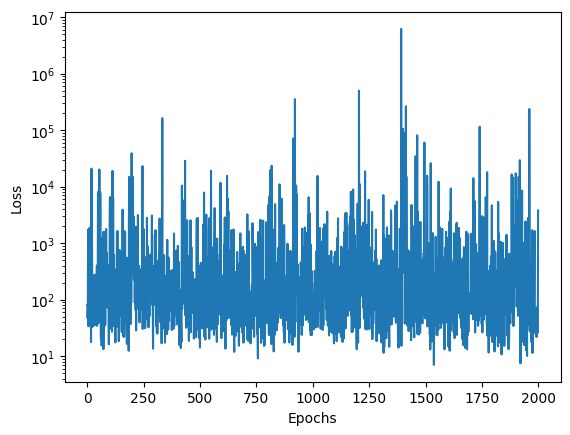

In [7]:

plt.plot(train_losses)
print(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()



tensor([[-1.2024e-01],
        [-3.1985e-01],
        [-2.9205e-02],
        [ 1.5714e-01],
        [-5.4988e-01],
        [-1.1728e-01],
        [-1.5462e-01],
        [-7.4700e-02],
        [-1.0367e-01],
        [-1.6982e-01],
        [-2.4395e-01],
        [-9.7855e-02],
        [-2.6849e-01],
        [-1.2389e-02],
        [-4.9156e-01],
        [ 1.4948e-01],
        [-4.2781e-01],
        [ 1.4538e-01],
        [-2.6608e-01],
        [-3.8207e-02],
        [-1.6485e-01],
        [ 1.0712e-01],
        [ 1.0656e-01],
        [-6.6410e-02],
        [-3.8506e-01],
        [-1.0505e-01],
        [-1.5055e-01],
        [-2.6066e-01],
        [ 1.8676e-02],
        [-2.8660e-01],
        [ 1.3304e-02],
        [-1.7413e-01],
        [-9.9089e-02],
        [-7.6245e-03],
        [-3.4559e-01],
        [-1.5946e-01],
        [-3.6253e-02],
        [-3.0935e-01],
        [ 9.9795e-02],
        [-2.0992e-01],
        [ 9.0300e-02],
        [ 3.4818e-04],
        [-4.0663e-01],
        [-1

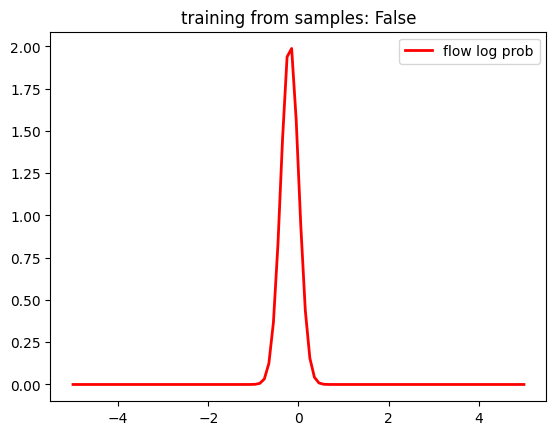

In [8]:

plt.figure()

# plot target
x_test = torch.linspace(-5, 5,steps = 100).reshape(-1,1)
# plt.plot(x_test, target_p(x_test), label = "target", color = "black")

# plot flow samples
z_samples = flow._distribution.sample(batch_size) 
x, _ = flow._transform(z_samples)  
# plt.hist(x.detach().cpu().numpy().reshape(-1,), bins = 40, density = True, label = "samples", color = "red", alpha = 0.5)

# plot flow log prob
z, dz_dx = flow._transform.inverse(x_test)  
px = (flow._distribution.log_prob(z) + dz_dx).exp()
print(x)
print(px)
plt.plot(x_test.detach().cpu().numpy(), px.detach().cpu().numpy(), label = "flow log prob", color = "red", lw = 2)

plt.legend()
plt.title("training from samples: "+str(train_from_samples))
plt.show()
